In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.32G/1.33G [00:05<00:00, 252MB/s]
100% 1.33G/1.33G [00:05<00:00, 251MB/s]


In [4]:
import zipfile
with zipfile.ZipFile("/content/celeba-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/dataset")

In [7]:
# Import required libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten


In [11]:
BASIC_PATH = "/content/dataset"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

In [12]:
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset: ", n_images)

Total Images in the Dataset:  202599


In [13]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(10)

<ipython-input-13-50b1fc984729>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1,'Male'] = "Female"


,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
5,176200.jpg,Female
6,041602.jpg,Female
7,065466.jpg,Male
8,019028.jpg,Male
9,164498.jpg,Female


**Sample Image**

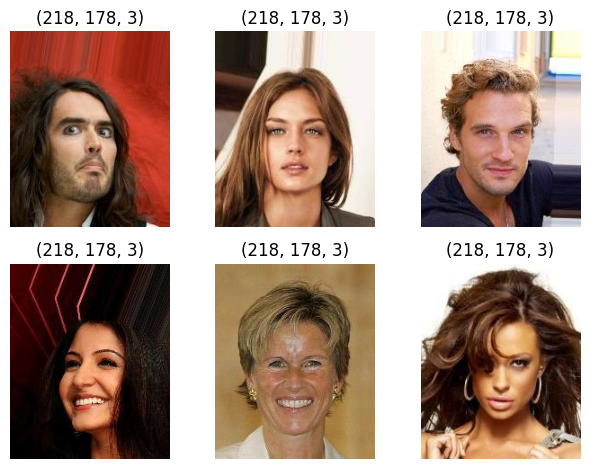

In [14]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Gender
Female    1442
Male      1058
Name: count, dtype: int64


In [16]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")



<ipython-input-16-7c7f24bf88fe>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_size = category_count[0] - category_count[1]


<Axes: xlabel='Gender'>

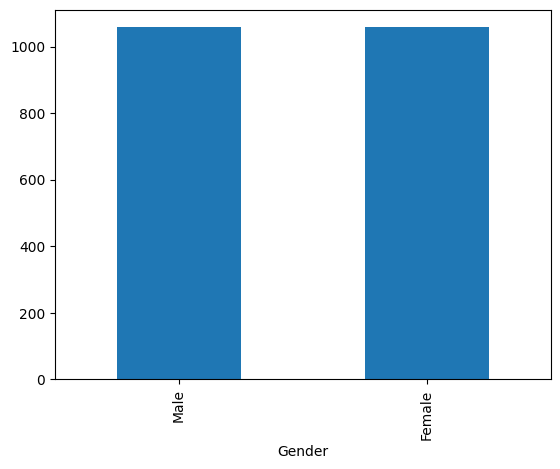

In [17]:
df["Gender"].value_counts().plot.bar()

**Training, Testing and Validation**

In [18]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [19]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1481
Total Test Sample Images :  425
Total Validation Sample Images :  210


**Create Image Data Generators for train and validation data**

In [48]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 64

In [49]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1481 validated image filenames belonging to 2 classes.


In [50]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 210 validated image filenames belonging to 2 classes.


In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 425 validated image filenames.


**Inception V3**

In [54]:
# prompt: buatkan model inception v3 imagenet

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer for binary classification
predictions = Dense(2, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
# I.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# At this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# Let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# We chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# We need to recompile the model for these modifications to take effect
# We use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# We train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

0 input_layer_9
1 conv2d_839
2 batch_normalization_839
3 activation_838
4 conv2d_840
5 batch_normalization_840
6 activation_839
7 conv2d_841
8 batch_normalization_841
9 activation_840
10 max_pooling2d_36
11 conv2d_842
12 batch_normalization_842
13 activation_841
14 conv2d_843
15 batch_normalization_843
16 activation_842
17 max_pooling2d_37
18 conv2d_847
19 batch_normalization_847
20 activation_846
21 conv2d_845
22 conv2d_848
23 batch_normalization_845
24 batch_normalization_848
25 activation_844
26 activation_847
27 average_pooling2d_80
28 conv2d_844
29 conv2d_846
30 conv2d_849
31 conv2d_850
32 batch_normalization_844
33 batch_normalization_846
34 batch_normalization_849
35 batch_normalization_850
36 activation_843
37 activation_845
38 activation_848
39 activation_849
40 mixed0
41 conv2d_854
42 batch_normalization_854
43 activation_853
44 conv2d_852
45 conv2d_855
46 batch_normalization_852
47 batch_normalization_855
48 activation_851
49 activation_854
50 average_pooling2d_81
51 conv2d_

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 241s 9s/step - accuracy: 0.7579 - loss: 0.4909 - val_accuracy: 0.8646 - val_loss: 0.4639
Epoch 2/5
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2:50 8s/step - accuracy: 0.9062 - loss: 0.2203

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 708ms/step - accuracy: 0.9062 - loss: 0.2203 - val_accuracy: 0.8333 - val_loss: 0.5907
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 211s 9s/step - accuracy: 0.9238 - loss: 0.2191 - val_accuracy: 0.9010 - val_loss: 0.2244
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 641ms/step - accuracy: 0.9375 - loss: 0.1475 - val_accuracy: 0.8889 - val_loss: 0.1849
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 211s 9s/step - accuracy: 0.9429 - loss: 0.1431 - val_accuracy: 0.9531 - val_loss: 0.1061


# Prediction & Testing the model

In [55]:
model.save("model.h5")

In [56]:
predict = model.predict(test_generator, steps=int(np.ceil(len(test_df)/BATCH_SIZE)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step


In [57]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [58]:
test_df

,image_id,Gender,Prediction
4,073193.jpg,Female,Female
1997,071990.jpg,Male,Male
1213,183728.jpg,Female,Female
1180,023502.jpg,Male,Female
592,093896.jpg,Female,Female
...,...,...,...
33,191989.jpg,Female,Female
823,147495.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Male


In [59]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[196,  10],
       [ 26, 193]])

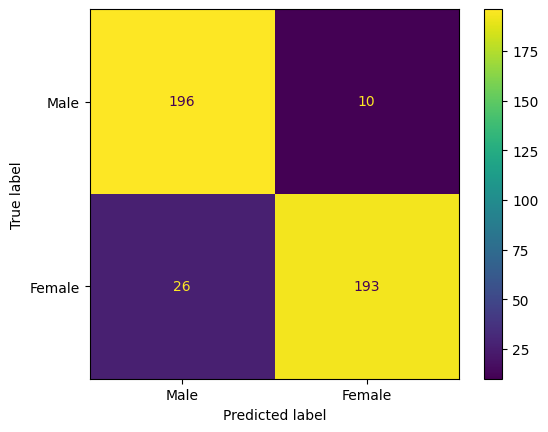

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [61]:
# prompt: print accuracy

loss, accuracy = model.evaluate(validation_generator)
print('Accuracy:', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.9528 - loss: 0.1141
Accuracy: 0.9523809552192688


In [62]:
# prompt: print presisi, recall dan f1score

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have 'test_df['Gender']' as true labels and 'test_df['Prediction']' as predicted labels
y_true = test_df['Gender']
y_pred = test_df['Prediction']

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.9178486977269938
Recall: 0.9152941176470588
F1-score: 0.9152716064500833
